<a href="https://colab.research.google.com/github/Gabriele90/ML-for-the-life-sciences-/blob/main/pyOpenMS_package.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ML IN PROTEOMICS**

Computing and data analysis in mass spectrometry is very diverse and in many cases must be tailored to a specific experiment. Often, multiple analysis steps have to be performed (identification,quantification, post-translational modification analysis, filtering, FDR analysis etc.) in an analysis pipeline, which requires high flexibility in the analysis.
Here, we will describe data analysis with Python using the pyOpenMS package.

*Installation*

In [25]:
!pip install pyopenms

In [26]:
import pyopenms

*Getting started*

In [27]:
from pyopenms import *
help(MSExperiment)

Help on class MSExperiment in module pyopenms.pyopenms_7:

class MSExperiment(builtins.object)
 |  Cython implementation of _MSExperiment
 |  
 |  Documentation is available at http://www.openms.de/current_doxygen/html/classOpenMS_1_1MSExperiment.html
 |   -- Inherits from ['ExperimentalSettings', 'RangeManager2']
 |  
 |  In-Memory representation of a mass spectrometry experiment.
 |  -----
 |  Contains the data and metadata of an experiment performed with an MS (or
 |  HPLC and MS). This representation of an MS experiment is organized as list
 |  of spectra and chromatograms and provides an in-memory representation of
 |  popular mass-spectrometric file formats such as mzXML or mzML. The
 |  meta-data associated with an experiment is contained in
 |  ExperimentalSettings (by inheritance) while the raw data (as well as
 |  spectra and chromatogram level meta data) is stored in objects of type
 |  MSSpectrum and MSChromatogram, which are accessible through the getSpectrum
 |  and getCh

pyOpenMS supports a variety of different files through the implementations in OpenMS.
In order to demonstrate the capabilities of pyOpenMS to read different mass spectrometric data files, we will download two files that have been prepared for this chapter and are available from Zenodo. which will load the content of the “example.mzML” file into the exp variable of type
MSExperiment. The file contains 3 spectra and 5 chromatograms, which we can see from the output of the code above.

In [28]:
from urllib.request import urlretrieve
from pyopenms import *
url = "https://zenodo.org/record/2653155/files/"
urlretrieve (url + "example.mzML", "example.mzML")
urlretrieve (url + "search.fasta", "search.fasta")
exp = MSExperiment()
MzMLFile().load("example.mzML", exp)

In [29]:
exp.getNrSpectra()

3

In [30]:
exp.getNrChromatograms()

5

*Plotting*

pyOpenMS has basic functionality to plot spectra and chromatograms, which we can now
try out on our file:

In [31]:
from pyopenms import *
exp = MSExperiment()
MzMLFile().load("example.mzML", exp)

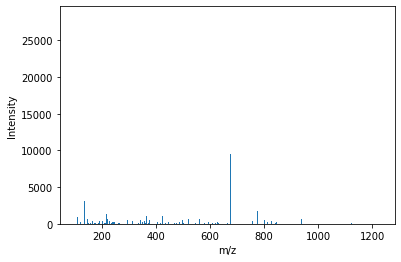

In [32]:
Plot.plotSpectrum(exp.getSpectrum(0))

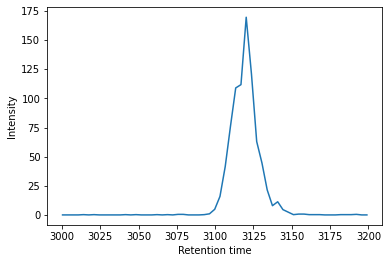

In [33]:
Plot.plotChromatogram(exp.getChromatogram(0))

*TheoreticalSpectrumGenerator*

This class implements a simple generator which generates tandem MS spectra from a given peptide charge combination. There are various options which influence the occurring ions and their intensities.

In [34]:
tsg = TheoreticalSpectrumGenerator()
spec1 = MSSpectrum()
spec2 = MSSpectrum()
peptide = AASequence.fromString("DFPIANGER")
# standard behavior is adding b- and y-ions of charge 1
p = Param()
p.setValue("add_b_ions", "false")
tsg.setParameters(p)
tsg.getSpectrum(spec1, peptide, 1, 1)
p.setValue("add_b_ions", "true")
p.setValue("add_a_ions", "true")
p.setValue("add_losses", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
tsg.getSpectrum(spec2, peptide, 1, 2)

In [35]:
print("Spectrum 1 has", spec1.size(), "peaks.")
print("Spectrum 2 has", spec2.size(), "peaks.")

Spectrum 1 has 8 peaks.
Spectrum 2 has 146 peaks.


In [36]:
for ion, peak in zip(spec2.getStringDataArrays()[0], spec2):
  print(ion, peak.getMZ())

b'a2-H2O1++' 51.53874357842103
b'b2-H2O1++' 65.53620107842102
b'y1-C1H2N1O1++' 66.05629515817103
b'y1-C1H2N2++' 67.05221565817102
b'y1-H3N1++' 79.54984014222102
b'y1++' 88.06311469007102
b'a3-H2O1++' 100.06512569007103
b'a2-H2O1+' 102.07021069007105
b'b3-H2O1++' 114.06258319007102
b'a2++' 118.05749819007102
b'b2-H2O1+' 130.06512569007106
b'y2-C1H2N1O1++' 130.57759226982103
b'y1-C1H2N1O1+' 131.10531384957102
b'y2-C1H2N2++' 131.573512769821
b'b2++' 132.054955690071
b'y1-C1H2N2+' 133.097154849571
b'y2-H2O1++' 143.579129269821
b'y2-H3N1++' 144.07113725387103
b'y2++' 152.58441180172102
b'a4-H2O1++' 156.607157865521
b'y1-H3N1+' 158.092403817671
b'y3-C1H2N1O1++' 159.08832431767104
b'y3-C1H2N2++' 160.08424481767102
b'a3++' 166.58388030172102
b'b4-H2O1++' 170.604615365521
b'y3-H2O1++' 172.08986131767102
b'y3-H3N1++' 172.58186930172104
b'y1+' 175.118952913371
b'b3++' 180.58133780172102
b'y3++' 181.09514384957103
b'a5-H2O1++' 192.125714945271
b'a3-H2O1+' 199.12297491337102
b'b5-H2O1++' 206.123172

The example shows how to put peaks of a certain type, y-ions in this case, into a spectrum.
Spectrum 2 is filled with a complete spectrum of all peaks (a-, b-, y-ions and losses). The TheoreticalSpectrumGenerator has many parameters which have a detailed description located in the class documentation. For the first spectrum, no b ions are added. Note how the add metainfo parameter in the second example populates the StringDataArray of the
output spectrum, allowing us to iterate over annotated ions and their masses.

*Filtering Spectra*

We will filter the “example.mzML” file by only retaining spectra that match a certain identifier:

In [37]:
from pyopenms import *
inp = MSExperiment()
MzMLFile().load("example.mzML", inp)

In [38]:
e = MSExperiment()
for s in inp:
  if s.getNativeID().startswith("scan="):
    e.addSpectrum(s)
    MzMLFile().store("test_filtered.mzML", e)

*Filtering by MS level*

Similarly, we can filter the example.mzML file by MS level, retaining only spectra that are not MS1 spectra (e.g. MS2, MS3 or MSn spectra):

In [39]:
from pyopenms import *
inp = MSExperiment()
MzMLFile().load("example.mzML", inp)

In [40]:
e = MSExperiment()
for s in inp:
  if s.getMSLevel() > 1:
    e.addSpectrum(s)
    MzMLFile().store("test_filtered.mzML", e)

Note that we can easily replace line 7 with more complicated criteria, such as filtering by MS level and scan identifier at the same time:

In [41]:
e = MSExperiment()
for s in inp:
  if s.getMSLevel() > 1 and s.getNativeID().startswith("scan="):
        e.addSpectrum(s)
        MzMLFile().store("test_filtered.mzML", e)

*Filtering by scan number*

Or we could use an external list of scan numbers to filter by scan numbers, thus only retaining MS scans in which we are interested in:

In [42]:
from pyopenms import *
inp = MSExperiment()
MzMLFile().load("example.mzML", inp)
scan_nrs = [0, 2, 5, 7]
e = MSExperiment()
for k, s in enumerate(inp):
  if k in scan_nrs and s.getMSLevel() == 1:
    e.addSpectrum(s)
    MzMLFile().store("test_filtered.mzML", e)

Filtering Spectra and Peaks

We can now move on to more advanced filtering, suppose we are interested in only a part
of all fragment ion spectra, such as a specific m/z window. We can easily filter our data
accordingly:

In [43]:
from pyopenms import *
inp = MSExperiment()
MzMLFile().load("example.mzML", inp)

In [44]:
mz_start = 6.0
mz_end = 12.0
e = MSExperiment()
for s in inp:
  if s.getMSLevel() > 1:
    filtered_mz = []
    filtered_int = []
    for mz, i in zip(*s.get_peaks()):
      if mz > mz_start and mz < mz_end:
        filtered_mz.append(mz)
        filtered_int.append(i)

In [45]:
s.set_peaks((filtered_mz, filtered_int))
e.addSpectrum(s)

In [46]:
MzMLFile().store("test_filtered.mzML", e)

*Peptide Search*

In MS-based proteomics, fragment ion spectra (MS2 spectra) are often interpreted by
comparing them against a theoretical set of spectra generated from a FASTA database.
OpenMS contains a (simple) implementation of such a “search engine” that compares experimental
spectra against theoretical spectra generated from a chemical or enzymatic digest
of a proteome.
In most proteomics applications, a dedicated search engine (such as Comet, Crux, Mascot,
MSGFPlus, MSFragger, Myrimatch, OMSSA, SpectraST or XTandem; all of which
are supported by pyOpenMS) will be used to search data. Here, we will use the internal
SimpleSearchEngineAlgorithm from OpenMS used for teaching purposes. This makes it
very easy to search an (experimental) mzML file against a fasta database of protein sequences:

In [48]:
from pyopenms import *

In [60]:
from urllib.request import urlretrieve
# from urllib import urlretrieve  # use this code for Python 2.x
from pyopenms import *
gh = "https://raw.githubusercontent.com/OpenMS/OpenMS/develop"
urlretrieve (gh +"/src/tests/topp/SimpleSearchEngine_1.mzML", "searchfile.mzML")
urlretrieve (gh +"/src/tests/topp/SimpleSearchEngine_1.fasta", "search.fasta")
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("searchfile.mzML", "search.fasta", protein_ids, peptide_ids)

This will print search engine output including the number of peptides and proteins in
the database and how many spectra were matched to peptides and proteins. We can now
investigate the individual peptide spectrum matches (PSM) using Python:

In [63]:
for peptide_id in peptide_ids:
  print (35*"=")
  print ("Peptide ID m/z:", peptide_id.getMZ())
  print ("Peptide ID rt:", peptide_id.getRT())
  print ("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
  print ("Peptide scan name:", peptide_id.getMetaValue("scan_index"))
  print ("Peptide ID score type:", peptide_id.getScoreType())
# PeptideHits
for hit in peptide_id.getHits():
  print(" - Peptide hit rank:", hit.getRank())
  print(" - Peptide hit charge:", hit.getCharge())
  print(" - Peptide hit sequence:", hit.getSequence())
  z = hit.getCharge()
  mz = hit.getSequence().getMonoWeight(Residue.ResidueType.Full, z) / z
  print(" - Peptide hit monoisotopic m/z:", mz)
  print(" - Peptide ppm error:", abs(mz - peptide_id.getMZ())/mz *10**6 )
  print(" - Peptide hit score:", hit.getScore())

Peptide ID m/z: 520.262817382812
Peptide ID rt: 2655.095703125
Peptide scan index: 0
Peptide scan name: 0
Peptide ID score type: hyperscore
Peptide ID m/z: 1063.20983886719
Peptide ID rt: 4587.6689453125
Peptide scan index: 1
Peptide scan name: 1
Peptide ID score type: hyperscore
Peptide ID m/z: 775.38720703125
Peptide ID rt: 4923.77734375
Peptide scan index: 2
Peptide scan name: 2
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit charge: 3
 - Peptide hit sequence: RPGADSDIGGFGGLFDLAQAGFR
 - Peptide hit monoisotopic m/z: 775.3854614376377
 - Peptide ppm error: 2.2512591467609693
 - Peptide hit score: 34.93666076660156


We notice that the second peptide spectrum match (PSM) was found for the third spectrum
in the file for a precursor at 775.38 m/z for the sequence RPGADSDIGGFGGLFDLAQAGFR

In [65]:
tsg = TheoreticalSpectrumGenerator()
thspec = MSSpectrum()
p = Param()
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = AASequence.fromString("RPGADSDIGGFGGLFDLAQAGFR")
tsg.getSpectrum(thspec, peptide, 1, 1)
for ion, peak in zip(thspec.getStringDataArrays()[0], thspec):
  print(ion, peak.getMZ())
  e = MSExperiment()
  MzMLFile().load("searchfile.mzML", e)
  print ("Spectrum native id", e[2].getNativeID() )
  mz,i = e[2].get_peaks()
  peaks = [(mz,i) for mz,i in zip(mz,i) if i > 1500 and mz > 300]
  for peak in peaks:
    print (peak[0], "mz", peak[1], "int")

b'y1+' 175.118952913371
Spectrum native id spectrum=2
877.4534301757812 mz 1753.01 int
926.434326171875 mz 1639.3121 int
1024.5223388671875 mz 2204.35 int
1187.544189453125 mz 1774.3148 int
b'b2+' 254.161152072871
Spectrum native id spectrum=2
877.4534301757812 mz 1753.01 int
926.434326171875 mz 1639.3121 int
1024.5223388671875 mz 2204.35 int
1187.544189453125 mz 1774.3148 int
b'b3+' 311.18261616857103
Spectrum native id spectrum=2
877.4534301757812 mz 1753.01 int
926.434326171875 mz 1639.3121 int
1024.5223388671875 mz 2204.35 int
1187.544189453125 mz 1774.3148 int
b'y2+' 322.1873672004711
Spectrum native id spectrum=2
877.4534301757812 mz 1753.01 int
926.434326171875 mz 1639.3121 int
1024.5223388671875 mz 2204.35 int
1187.544189453125 mz 1774.3148 int
b'y3+' 379.2088312961711
Spectrum native id spectrum=2
877.4534301757812 mz 1753.01 int
926.434326171875 mz 1639.3121 int
1024.5223388671875 mz 2204.35 int
1187.544189453125 mz 1774.3148 int
b'b4+' 382.219730328071
Spectrum native id spe

Comparing the theoretical spectrum and the experimental spectrum for
RPGADSDIGGFGGLFDLAQAGFR we can easily see that the most abundant ions in the
spectrum are y8 (877.452 m/z), b10 (926.432), y9 (1024.522 m/z) and b13 (1187.544 m/z).